In [1]:
bounds = {
    "170K": [7.0, 9.0],
    "170I": [5.5, 9.5],
    "2060C05": [3.5, 5.0],
    "3105A07": [5.0, 8.0]
}

# from bounds import bounds
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

class CooperStandard:
    """
    A class to handle loading, preprocessing, categorizing, normalizing, and splitting batch process data.
    """
    def __init__(self, file_path, sheet_names, variable_names):
        self.file_path = file_path
        self.sheet_names = sheet_names
        self.variable_names = variable_names
        self.df = None
        self.scaler_params = None  # To store min/max for scalar and time series features

    def load_data(self):
        try:
            self.df = pd.concat(
                [pd.read_excel(self.file_path, sheet_name=sheet, usecols=self.variable_names, dtype=str)
                 for sheet in self.sheet_names],
                ignore_index=True
            )
            for col in ["MDRTorqueS1", "MDRTorqueS2"]:
                if col in self.df.columns:
                    self.df[col] = self.df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
            self.df = self.df.apply(pd.to_numeric, errors='ignore')
            for col in ["start_time", "end_time"]:
                if col in self.df.columns:
                    self.df[col] = pd.to_datetime(self.df[col], errors='coerce')
        except FileNotFoundError:
            raise FileNotFoundError(f"Error: The file '{self.file_path}' was not found.")
        except ValueError as e:
            raise ValueError(f"Error loading sheets: {e}")
        return self.df

    def _check_columns(self, required_cols):
        missing_columns = [col for col in required_cols if col not in self.df.columns]
        if missing_columns:
            raise ValueError(f"Missing columns in the dataset: {missing_columns}")

    def df_variables(self):
        if self.df is None:
            raise ValueError("Data not loaded. Please call load_data() first.")
        self._check_columns(self.variable_names)
        return self.df[self.variable_names]

    def preprocessing(self, length_threshold=300):
        if self.df is None:
            raise ValueError("Data not loaded. Please call load_data() first.")
        df_vars = self.df_variables().dropna().copy()
        df_vars["end-start"] = (df_vars["end_time"] - df_vars["start_time"]).dt.total_seconds()
        df_vars.drop(columns=["start_time", "end_time"], inplace=True)
        mask = (df_vars["MDRTorqueS1"].str.len() >= length_threshold) & \
               (df_vars["MDRTorqueS2"].str.len() >= length_threshold)
        removed_batches = {
            row["batch_number"]: {"len(S1)=len(S2)": len(row["MDRTorqueS1"])}
            for _, row in df_vars[~mask].iterrows()
        }
        return df_vars[mask].reset_index(drop=True), removed_batches

    def convert_to_dict(self, df, fixed_length=None):
        batch_dict = {}
        # If fixed_length is provided, use it; otherwise compute the minimum from this df.
        if fixed_length is None:
            min_length = min(
                min(len(row["MDRTorqueS1"]), len(row["MDRTorqueS2"])) for _, row in df.iterrows()
            )
        else:
            min_length = fixed_length

        for _, row in df.iterrows():
            batch_number = row["batch_number"]
            scalar_features = [
                row["mh"], row["ml"], row["TimeAtML"], row["TimeAtML_min"],
                row["ml_min"], row["end-start"]
            ]
            # Truncate both time series to the determined min_length.
            ts1_truncated = row["MDRTorqueS1"][:min_length]
            ts2_truncated = row["MDRTorqueS2"][:min_length]

            time_values = [pair[0] for pair in ts1_truncated]
            S1_values = [pair[1] for pair in ts1_truncated]
            S2_values = [pair[1] for pair in ts2_truncated]

            temp_df = pd.DataFrame({"time": time_values, "S1": S1_values, "S2": S2_values})
            temp_df = temp_df.interpolate(method="linear").bfill().ffill()

            if temp_df.isnull().values.any():
                raise ValueError(f"NaN values remain in time series for batch {batch_number} after interpolation.")

            S1_S2_ratio = temp_df["S1"] / (temp_df["S2"] + 1e-8)
            time_series = np.column_stack((temp_df["time"], temp_df["S1"], temp_df["S2"], S1_S2_ratio))

            batch_dict[batch_number] = {
                "scalar_features": scalar_features,
                "time_series": time_series,
                "t5": row["t5"]
            }
        return batch_dict


    def normalize_data(self, data_dict, fit=False):
        """
        Normalizes scalar features and time series using min-max scaling.

        Args:
            data_dict (dict): Dictionary from convert_to_dict with batch data.
            fit (bool): If True, compute min/max from this data; if False, use stored scaler_params.

        Returns:
            dict: Normalized data dictionary.
        """
        if fit:
            # Compute min/max for scalar features and time series from training data
            scalar_values = np.array([d["scalar_features"] for d in data_dict.values()])
            time_series_values = np.concatenate([d["time_series"] for d in data_dict.values()], axis=0)

            self.scaler_params = {
                "scalar_min": scalar_values.min(axis=0),
                "scalar_max": scalar_values.max(axis=0),
                "ts_min": time_series_values.min(axis=0),
                "ts_max": time_series_values.max(axis=0)
            }

        if self.scaler_params is None:
            raise ValueError("Scaler parameters not initialized. Run with fit=True on training data first.")

        # Normalize the data
        normalized_dict = {}
        for batch_number, data in data_dict.items():
            # Normalize scalar features
            scalar_norm = (np.array(data["scalar_features"]) - self.scaler_params["scalar_min"]) / \
                          (self.scaler_params["scalar_max"] - self.scaler_params["scalar_min"] + 1e-8)

            # Normalize time series
            ts_norm = (data["time_series"] - self.scaler_params["ts_min"]) / \
                      (self.scaler_params["ts_max"] - self.scaler_params["ts_min"] + 1e-8)

            normalized_dict[batch_number] = {
                "scalar_features": scalar_norm.tolist(),
                "time_series": ts_norm,
                "t5": data["t5"]  # Leave t5 unnormalized (can be normalized separately if needed)
            }
        return normalized_dict

    def split_data(self, data_dict, train_size=0.7, val_size=0.15, test_size=0.15, random_state=None):
        """
        Splits the data dictionary into train, validation, and test sets.

        Args:
            data_dict (dict): Dictionary from convert_to_dict.
            train_size (float): Proportion of data for training.
            val_size (float): Proportion of data for validation.
            test_size (float): Proportion of data for testing.
            random_state (int): Seed for reproducibility.

        Returns:
            tuple: (train_dict, val_dict, test_dict)
        """
        if abs(train_size + val_size + test_size - 1.0) > 1e-6:
            raise ValueError("Train, validation, and test sizes must sum to 1.0")

        batch_numbers = list(data_dict.keys())
        train_batches, temp_batches = train_test_split(
            batch_numbers, train_size=train_size, random_state=random_state
        )
        val_relative_size = val_size / (val_size + test_size)
        val_batches, test_batches = train_test_split(
            temp_batches, train_size=val_relative_size, random_state=random_state
        )

        train_dict = {k: data_dict[k] for k in train_batches}
        val_dict = {k: data_dict[k] for k in val_batches}
        test_dict = {k: data_dict[k] for k in test_batches}

        return train_dict, val_dict, test_dict

    def print_t5_categories(self, data_dict, lb, ub):
        # Initialize counters for each category
        low_count = 0
        normal_count = 0
        high_count = 0

        # Iterate through the dictionary values to access each batch
        for batch in data_dict.values():
            t5 = batch['t5']  # Extract the 't5' value

            # Categorize based on t5 value
            if t5 < lb:
                low_count += 1
            elif lb <= t5 <= ub:
                normal_count += 1
            else:  # t5 > ub
                high_count += 1

        # Calculate total number of batches
        total = len(data_dict)

        # Print the results
        print(f"Total number of batches: {total}")
        print(f"Number of low batches (t5 < {lb}): {low_count}")
        print(f"Number of normal batches ({lb} <= t5 <= {ub}): {normal_count}")
        print(f"Number of high batches (t5 > {ub}): {high_count}\n")

    def balance_data_with_synthetic(self, df, lb, ub, k=5):
        """
        Generate synthetic data for minority classes (t5 < lb and t5 > ub)
        using a SMOTE-like approach that takes into account the interactions among
        scalar features and time-series summary statistics.

        This method first labels each row as "low", "normal", or "high" based on t5,
        determines the number of samples needed to match the majority region, and then
        generates synthetic samples via interpolation between k-nearest neighbors.

        Args:
            df (pd.DataFrame): DataFrame after preprocessing.
            lb (float): Lower bound for t5.
            ub (float): Upper bound for t5.
            k (int): Number of neighbors to consider.

        Returns:
            pd.DataFrame: The augmented DataFrame including synthetic samples.
        """
        df_aug = df.copy()
        # Label each row with its region.
        df_aug["region"] = df_aug["t5"].apply(lambda x: "low" if x < lb else ("high" if x > ub else "normal"))
        region_counts = df_aug["region"].value_counts()
        target_count = region_counts.max()
        synthetic_rows = []

        # Define scalar columns used later (including the target t5 in the NN feature vector)
        scalar_cols = ["mh", "ml", "TimeAtML", "TimeAtML_min", "ml_min", "end-start"]
        scalar_cols_for_nn = scalar_cols + ["t5"]
        ts_cols = ["MDRTorqueS1", "MDRTorqueS2"]

        # Function to compute a simple summary statistic (mean measurement) for a time series.
        def ts_summary(row, col):
            ts_list = row[col]
            arr = np.array(ts_list)
            return arr[:, 1].mean() if len(arr) > 0 else 0

        # Build a feature vector combining scalar features, t5, and time-series summaries.
        def build_feature_vector(row):
            scalar_feats = [float(row[col]) for col in scalar_cols_for_nn]
            ts_feats = [ts_summary(row, col) for col in ts_cols]
            return np.array(scalar_feats + ts_feats)

        from sklearn.neighbors import NearestNeighbors
        # Process only the minority regions ("low" and "high").
        for region in ["low", "high"]:
            region_df = df_aug[df_aug["region"] == region].reset_index(drop=True)
            n_current = len(region_df)
            n_to_generate = target_count - n_current
            if n_to_generate <= 0:
                continue

            features = region_df.apply(build_feature_vector, axis=1).tolist()
            features = np.vstack(features)

            nn = NearestNeighbors(n_neighbors=min(k, len(region_df)))
            nn.fit(features)

            for i in range(n_to_generate):
                idx = np.random.randint(0, len(region_df))
                sample = region_df.iloc[idx]
                distances, indices = nn.kneighbors(features[idx:idx+1])
                neighbor_indices = indices[0][indices[0] != idx]
                if len(neighbor_indices) == 0:
                    neighbor_idx = idx
                else:
                    neighbor_idx = np.random.choice(neighbor_indices)
                sample_neighbor = region_df.iloc[neighbor_idx]
                gap = np.random.rand()  # interpolation factor in [0,1]

                synthetic_sample = {}
                synthetic_sample["batch_number"] = f"synthetic_{region}_{i+1}_{np.random.randint(10000)}"

                # Interpolate scalar features (explicitly convert to float).
                for col in scalar_cols:
                    try:
                        val1 = float(sample[col])
                        val2 = float(sample_neighbor[col])
                        interpolated = val1 + gap * (val2 - val1)
                    except Exception as e:
                        print(f"Error interpolating column {col}: {e}")
                        interpolated = np.nan
                    synthetic_sample[col] = interpolated
                    if np.isnan(interpolated):
                        print(f"DEBUG: {col} interpolation resulted in NaN (sample: {sample[col]}, neighbor: {sample_neighbor[col]}, gap: {gap})")

                # Interpolate the target t5.
                try:
                    t5_val = float(sample["t5"]) + gap * (float(sample_neighbor["t5"]) - float(sample["t5"]))
                except Exception as e:
                    print(f"Error interpolating t5: {e}")
                    t5_val = np.nan
                synthetic_sample["t5"] = t5_val
                if np.isnan(t5_val):
                    print(f"DEBUG: t5 interpolation resulted in NaN (sample: {sample['t5']}, neighbor: {sample_neighbor['t5']}, gap: {gap})")

                # Interpolate time-series data elementwise.
                def interpolate_ts(ts1, ts2, gap):
                    length = min(len(ts1), len(ts2))
                    syn_ts = []
                    for j in range(length):
                        try:
                            time_val = ts1[j][0] + gap * (ts2[j][0] - ts1[j][0])
                            meas_val = ts1[j][1] + gap * (ts2[j][1] - ts1[j][1])
                        except Exception as e:
                            print(f"Error interpolating time-series at index {j}: {e}")
                            time_val, meas_val = np.nan, np.nan
                        syn_ts.append([time_val, meas_val])
                    return syn_ts

                for col in ts_cols:
                    synthetic_sample[col] = interpolate_ts(sample[col], sample_neighbor[col], gap)

                # Optionally interpolate start_time and end_time if they exist.
                for time_col in ["start_time", "end_time"]:
                    if time_col in sample and pd.notnull(sample[time_col]) and pd.notnull(sample_neighbor[time_col]):
                        try:
                            t1 = sample[time_col].value
                            t2 = sample_neighbor[time_col].value
                            syn_time = pd.to_datetime(t1 + gap * (t2 - t1))
                        except Exception as e:
                            print(f"Error interpolating {time_col}: {e}")
                            syn_time = pd.NaT
                        synthetic_sample[time_col] = syn_time

                synthetic_rows.append(synthetic_sample)

        if synthetic_rows:
            synthetic_df = pd.DataFrame(synthetic_rows)
            df_final = pd.concat([df_aug.drop(columns=["region"]), synthetic_df], ignore_index=True)
        else:
            df_final = df_aug.drop(columns=["region"])

        return df_final


# experiment_runner.py
# from cooper_standard import CooperStandard
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate

class ExperimentRunner:
    # def __init__(self, file_path, sheet_names, variables):
    #     self.file_path = file_path
    #     self.sheet_names = sheet_names
    #     self.variables = variables
    #     # Here we assume we use the bounds for "2060C05"
    #     self.lb, self.ub = bounds["2060C05"]
    #     self.cooper_standard = CooperStandard(file_path, sheet_names, variables)

    def __init__(self, file_path, sheet_names, compound_name, variables):
        self.file_path = file_path
        self.sheet_names = sheet_names
        self.variables = variables
        self.lb, self.ub = bounds[compound_name]
        self.cooper_standard = CooperStandard(file_path, sheet_names, variables)

    def load_and_preprocess(self):
        # Load data and apply preprocessing
        df_all = self.cooper_standard.load_data()
        cleaned_df, removed_batches = self.cooper_standard.preprocessing(280)
        return cleaned_df

    def split_and_augment(self, df, use_augmentation):
        # Split the cleaned dataframe into train, validation, and test sets.
        train_df, temp_df = train_test_split(df, train_size=0.7, random_state=42)
        val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)
        if use_augmentation:
            print("Augmenting training data for balancing...")
            train_df = self.cooper_standard.balance_data_with_synthetic(train_df, self.lb, self.ub, k=5)
        else:
            print("Using original training data without augmentation.")
        return train_df, val_df, test_df

    def count_regions(self, df):
        # Count the number of datapoints for each region based on t5.
        def categorize(t5):
            if t5 < self.lb:
                return "low"
            elif t5 <= self.ub:
                return "normal"
            else:
                return "high"
        regions = df["t5"].apply(categorize)
        counts = regions.value_counts().to_dict()
        # Ensure all keys exist.
        for region in ["low", "normal", "high"]:
            if region not in counts:
                counts[region] = 0
        return counts

    def convert_and_normalize(self, train_df, val_df, test_df):
        # Convert dataframes into dictionaries and normalize.
        train_dict = self.cooper_standard.convert_to_dict(train_df)
        # Determine a fixed time series length based on the training data.
        fixed_length = list(train_dict.values())[0]["time_series"].shape[0]
        val_dict = self.cooper_standard.convert_to_dict(val_df, fixed_length=fixed_length)
        test_dict = self.cooper_standard.convert_to_dict(test_df, fixed_length=fixed_length)
        train_dict_norm = self.cooper_standard.normalize_data(train_dict, fit=True)
        val_dict_norm = self.cooper_standard.normalize_data(val_dict, fit=False)
        test_dict_norm = self.cooper_standard.normalize_data(test_dict, fit=False)
        return train_dict_norm, val_dict_norm, test_dict_norm

    def prepare_data_from_dict(self, data_dict):
        # Prepare arrays for time series, scalar features, and target t5.
        time_series = np.array([batch["time_series"] for batch in data_dict.values()])
        scalar_features = np.array([batch["scalar_features"] for batch in data_dict.values()])
        targets = np.array([batch["t5"] for batch in data_dict.values()])
        return time_series, scalar_features, targets

    def build_model(self, sequence_length, num_scalar_features):
        # Build a dual-input neural network model.
        ts_input = Input(shape=(sequence_length, 4), name='time_series_input')
        lstm_out = LSTM(units=64)(ts_input)
        scalar_input = Input(shape=(num_scalar_features,), name='scalar_input')
        scalar_dense = Dense(16, activation='relu')(scalar_input)
        combined = Concatenate()([lstm_out, scalar_dense])
        dense = Dense(32, activation='relu')(combined)
        output = Dense(1, name='t5_output')(dense)
        model = Model(inputs=[ts_input, scalar_input], outputs=output)
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def compute_class_metrics(self, true_t5, pred_t5):
        # Compute MSE, MAE, and accuracy per region.
        metrics = {}
        regions = {
            "low": (true_t5 < self.lb),
            "normal": ((true_t5 >= self.lb) & (true_t5 <= self.ub)),
            "high": (true_t5 > self.ub)
        }
        for region, mask in regions.items():
            count = np.sum(mask)
            if count == 0:
                metrics[region] = {"mse": np.nan, "mae": np.nan, "accuracy": np.nan, "datapoints": 0}
            else:
                mse_val = np.mean((true_t5[mask] - pred_t5[mask]) ** 2)
                mae_val = np.mean(np.abs(true_t5[mask] - pred_t5[mask]))
                # Define region accuracy: percentage of predictions that fall in the same region.
                if region == "low":
                    acc = np.mean(pred_t5[mask] < self.lb) * 100
                elif region == "normal":
                    acc = np.mean((pred_t5[mask] >= self.lb) & (pred_t5[mask] <= self.ub)) * 100
                else:  # high
                    acc = np.mean(pred_t5[mask] > self.ub) * 100
                metrics[region] = {"mse": mse_val, "mae": mae_val, "accuracy": acc, "datapoints": int(count)}
        return metrics

    def run_experiment(self, use_augmentation):
        # Load and preprocess data.
        df_clean = self.load_and_preprocess()
        # Split (and augment training if selected).
        train_df, val_df, test_df = self.split_and_augment(df_clean, use_augmentation)
        # Count datapoints per region.
        train_counts = self.count_regions(train_df)
        val_counts = self.count_regions(val_df)
        test_counts = self.count_regions(test_df)
        # Convert data and normalize.
        train_dict_norm, val_dict_norm, test_dict_norm = self.convert_and_normalize(train_df, val_df, test_df)
        # Prepare arrays for training.
        train_ts, train_scalar, train_targets = self.prepare_data_from_dict(train_dict_norm)
        val_ts, val_scalar, val_targets = self.prepare_data_from_dict(val_dict_norm)
        test_ts, test_scalar, test_targets = self.prepare_data_from_dict(test_dict_norm)
        # Build the model.
        sequence_length = train_ts.shape[1]
        num_scalar_features = train_scalar.shape[1]
        model = self.build_model(sequence_length, num_scalar_features)
        # Train the model.
        history = model.fit(
            [train_ts, train_scalar], train_targets,
            validation_data=([val_ts, val_scalar], val_targets),
            epochs=50,
            batch_size=32,
            verbose=0
        )
        # Evaluate overall performance.
        train_loss, train_mae = model.evaluate([train_ts, train_scalar], train_targets, verbose=0)
        val_loss, val_mae = model.evaluate([val_ts, val_scalar], val_targets, verbose=0)
        test_loss, test_mae = model.evaluate([test_ts, test_scalar], test_targets, verbose=0)
        # Make predictions.
        train_pred = model.predict([train_ts, train_scalar]).flatten()
        val_pred = model.predict([val_ts, val_scalar]).flatten()
        test_pred = model.predict([test_ts, test_scalar]).flatten()
        # Compute per-region metrics.
        train_metrics = self.compute_class_metrics(train_targets, train_pred)
        val_metrics = self.compute_class_metrics(val_targets, val_pred)
        test_metrics = self.compute_class_metrics(test_targets, test_pred)

        # Save predicted t5 values
        predictions = {
            "train": {"actual": train_targets, "predicted": train_pred},
            "val": {"actual": val_targets, "predicted": val_pred},
            "test": {"actual": test_targets, "predicted": test_pred}
        }

        # Bundle the results.
        results = {
            "augmentation": use_augmentation,
            "datapoints": {
                "train": train_counts,
                "val": val_counts,
                "test": test_counts
            },
            "performance": {
                "train": train_metrics,
                "val": val_metrics,
                "test": test_metrics
            },
            "predictions": predictions  # Add predictions to the results
        }

        return results

def create_combined_plot(no_aug_results, aug_results, experiment, compound_name):
    """
    Create a combined plot showing normalized predicted vs real t5 for both scenarios,
    with boxed annotations "Without data augmentation" and "With data augmentation"
    centered above each subplot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    scenarios = [
        {"results": no_aug_results, "title": "Without Augmentation", "ax": axes[0]},
        {"results": aug_results,    "title": "With Augmentation",    "ax": axes[1]}
    ]

    for scenario in scenarios:
        ax = scenario["ax"]
        results = scenario["results"]

        # Use only test data
        actual    = results["predictions"]["test"]["actual"]
        predicted = results["predictions"]["test"]["predicted"]

        # Normalize t5 values to [0,1] range
        min_t5 = min(min(actual), min(predicted))
        max_t5 = max(max(actual), max(predicted))
        norm_actual    = (actual    - min_t5) / (max_t5 - min_t5)
        norm_predicted = (predicted - min_t5) / (max_t5 - min_t5)

        # Normalize region boundaries
        lb, ub    = experiment.lb, experiment.ub
        norm_lb   = (lb - min_t5) / (max_t5 - min_t5)
        norm_ub   = (ub - min_t5) / (max_t5 - min_t5)

        # Define regions (using original values for categorization)
        low_mask    = actual < lb
        normal_mask = (actual >= lb) & (actual <= ub)
        high_mask   = actual > ub

        # Plot points
        ax.scatter(norm_actual[low_mask],    norm_predicted[low_mask],    color='dodgerblue',  label='Low',    alpha=0.7)
        ax.scatter(norm_actual[normal_mask], norm_predicted[normal_mask], color='mediumseagreen', label='Normal', alpha=0.7)
        ax.scatter(norm_actual[high_mask],   norm_predicted[high_mask],   color='crimson',   label='High',   alpha=0.7)

        # Plot 45-degree line
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # No grid
        ax.grid(False)

        # Add region boundaries
        ax.axhline(y=norm_lb, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=norm_ub, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(x=norm_lb, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(x=norm_ub, color='gray', linestyle=':', alpha=0.5)

        # Labels and title
        ax.set_xlabel(r'$t_5^{real}$')
        ax.set_ylabel(r'$t_5^{pred}$')
        # ax.set_title(f"Testing Set - {scenario['title']}")

        # Boxed annotation centered above x-axis
        scenario_text = scenario["title"].replace("Augmentation", "data augmentation")
        ax.text(
            0.5, 0.95,                  # x=50% of axis, y just above the top
            scenario_text,
            transform=ax.transAxes,     # use axis coordinates
            ha='center',
            va='bottom',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
        )

        # Set axis limits
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)

        # Legend
        ax.legend(loc='upper left')

    plt.tight_layout()
    plt.savefig(f"{compound_name}.eps", dpi=500, bbox_inches='tight')
    plt.show()
    # plt.close()

# **3105A07**

Mounted at /content/drive
Using original training data without augmentation.
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Augmenting training data for balancing...
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


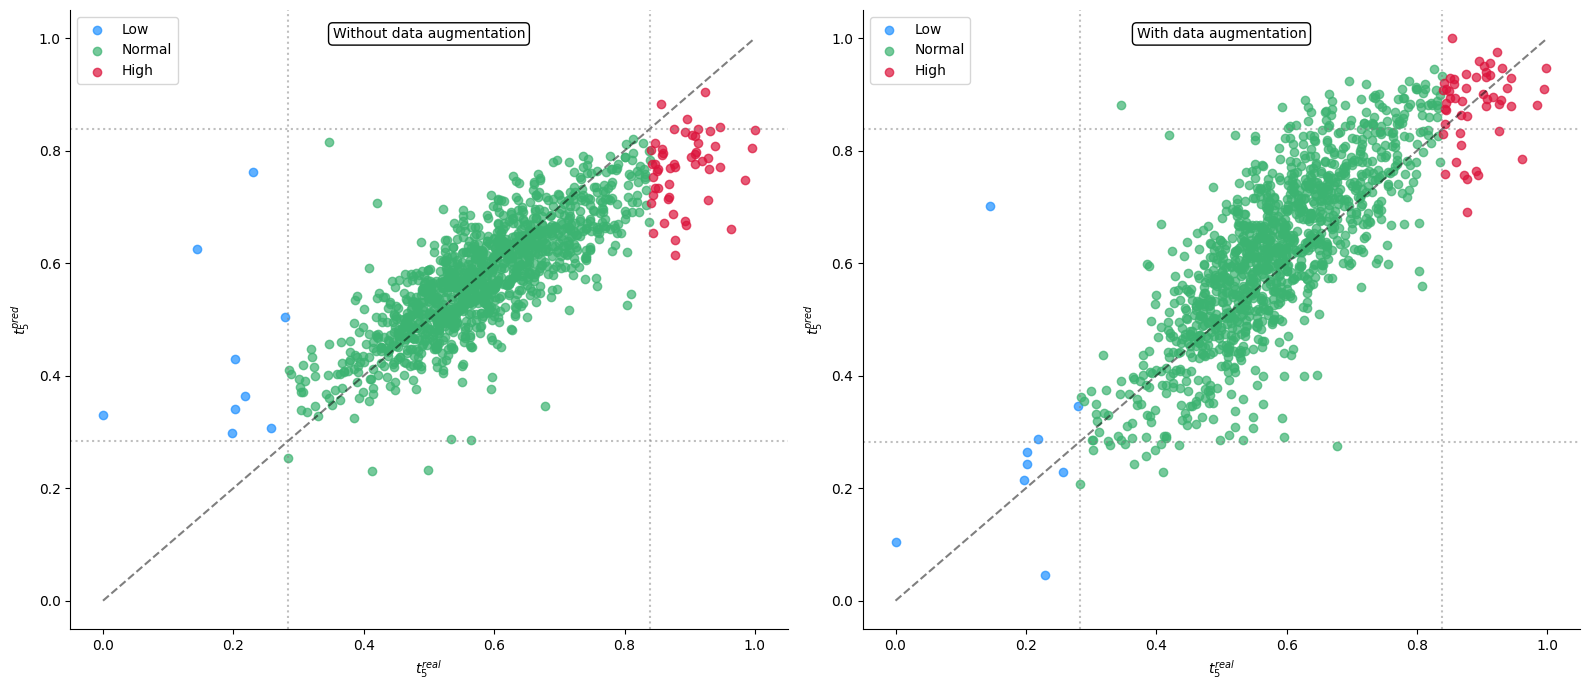

,Scenario,Dataset,Region,DataPoints,MSE,MAE,Accuracy
0,No Augmentation,train,low,59,0.947610,0.825682,8.474576
1,No Augmentation,train,normal,5617,0.137855,0.282039,99.537119
2,No Augmentation,train,high,191,0.649957,0.699624,12.565445
3,No Augmentation,val,low,16,0.421468,0.577732,18.750000
4,No Augmentation,val,normal,1195,0.212075,0.276557,99.832636
5,No Augmentation,val,high,46,0.541214,0.643030,19.565217
6,No Augmentation,test,low,9,2.523082,1.338750,0.000000
7,No Augmentation,test,normal,1197,0.130056,0.274587,99.749373
8,No Augmentation,test,high,52,0.567741,0.668382,9.615385
9,Augmentation,train,low,5617,0.093659,0.232682,82.891223


In [2]:
import pandas as pd
from google.colab import drive
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Mohammad/CooperStandard')

# Configuration parameters.
file_path = "/content/drive/MyDrive/Mohammad/CooperStandard/DataOn2025Jan08.xlsx"
sheet_names = ["NES3105A07Line1", "NES3105A07Line2"]
compound_name = "3105A07"
variables = [
    "batch_number", "MDRTorqueS1", "MDRTorqueS2",
    "mh", "ml", "TimeAtML", "TimeAtML_min", "ml_min",
    "start_time", "end_time", "t5"
]

# Instantiate the experiment runner.
experiment_3105A07 = ExperimentRunner(file_path, sheet_names, compound_name, variables)

# Run experiments for both scenarios.
results_no_aug_3105A07 = experiment_3105A07.run_experiment(use_augmentation=False)
results_aug_3105A07 = experiment_3105A07.run_experiment(use_augmentation=True)

# Build a results DataFrame.
rows = []
for scenario, result in [("No Augmentation", results_no_aug_3105A07), ("Augmentation", results_aug_3105A07)]:
    for dataset in ["train", "val", "test"]:
        dp_counts = result["datapoints"][dataset]
        perf = result["performance"][dataset]
        for region in ["low", "normal", "high"]:
            row = {
                "Scenario": scenario,
                "Dataset": dataset,
                "Region": region,
                "DataPoints": dp_counts.get(region, 0),
                "MSE": perf.get(region, {}).get("mse", None),
                "MAE": perf.get(region, {}).get("mae", None),
                "Accuracy": perf.get(region, {}).get("accuracy", None)
            }
            rows.append(row)

create_combined_plot(results_no_aug_3105A07, results_aug_3105A07, experiment_3105A07, compound_name)
results_df_3105A07 = pd.DataFrame(rows)
results_df_3105A07

# **170I**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using original training data without augmentation.
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Augmenting training data for balancing...
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


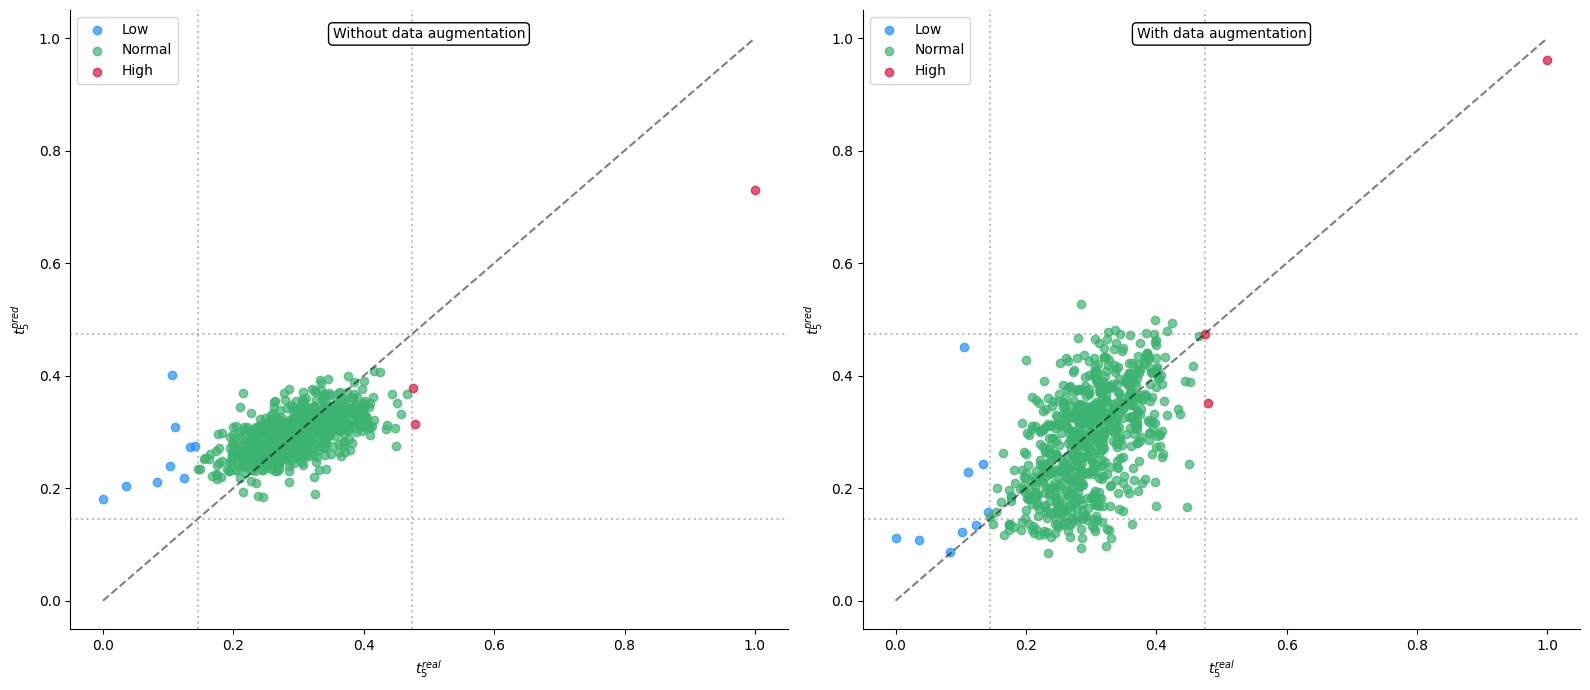

,Scenario,Dataset,Region,DataPoints,MSE,MAE,Accuracy
0,No Augmentation,train,low,46,2.765115,1.572594,0.000000
1,No Augmentation,train,normal,3384,0.373207,0.487232,99.970440
2,No Augmentation,train,high,9,4.962076,1.922073,33.333333
3,No Augmentation,val,low,9,2.374328,1.510284,0.000000
4,No Augmentation,val,normal,726,0.393350,0.484200,100.000000
5,No Augmentation,val,high,2,3.794786,1.892090,50.000000
6,No Augmentation,test,low,9,4.423249,1.993087,0.000000
7,No Augmentation,test,normal,726,0.327082,0.453934,100.000000
8,No Augmentation,test,high,3,5.377989,2.150084,33.333333
9,Augmentation,train,low,3384,0.257920,0.374351,77.866430


In [3]:
import pandas as pd
from google.colab import drive
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Mohammad/CooperStandard')

# Configuration parameters.
file_path = "/content/drive/MyDrive/Mohammad/CooperStandard/DataOn2025Jan08.xlsx"
sheet_names = ["NES170I08Line1"]
compound_name = "170I"
variables = [
    "batch_number", "MDRTorqueS1", "MDRTorqueS2",
    "mh", "ml", "TimeAtML", "TimeAtML_min", "ml_min",
    "start_time", "end_time", "t5"
]

# Instantiate the experiment runner.
experiment_170I = ExperimentRunner(file_path, sheet_names, compound_name, variables)

# Run experiments for both scenarios.
results_no_aug_170I = experiment_170I.run_experiment(use_augmentation=False)
results_aug_170I = experiment_170I.run_experiment(use_augmentation=True)

# Build a results DataFrame.
rows = []
for scenario, result in [("No Augmentation", results_no_aug_170I), ("Augmentation", results_aug_170I)]:
    for dataset in ["train", "val", "test"]:
        dp_counts = result["datapoints"][dataset]
        perf = result["performance"][dataset]
        for region in ["low", "normal", "high"]:
            row = {
                "Scenario": scenario,
                "Dataset": dataset,
                "Region": region,
                "DataPoints": dp_counts.get(region, 0),
                "MSE": perf.get(region, {}).get("mse", None),
                "MAE": perf.get(region, {}).get("mae", None),
                "Accuracy": perf.get(region, {}).get("accuracy", None)
            }
            rows.append(row)

create_combined_plot(results_no_aug_170I, results_aug_170I, experiment_170I, compound_name)
results_df_170I = pd.DataFrame(rows)
results_df_170I

# **170K**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using original training data without augmentation.
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Augmenting training data for balancing...
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


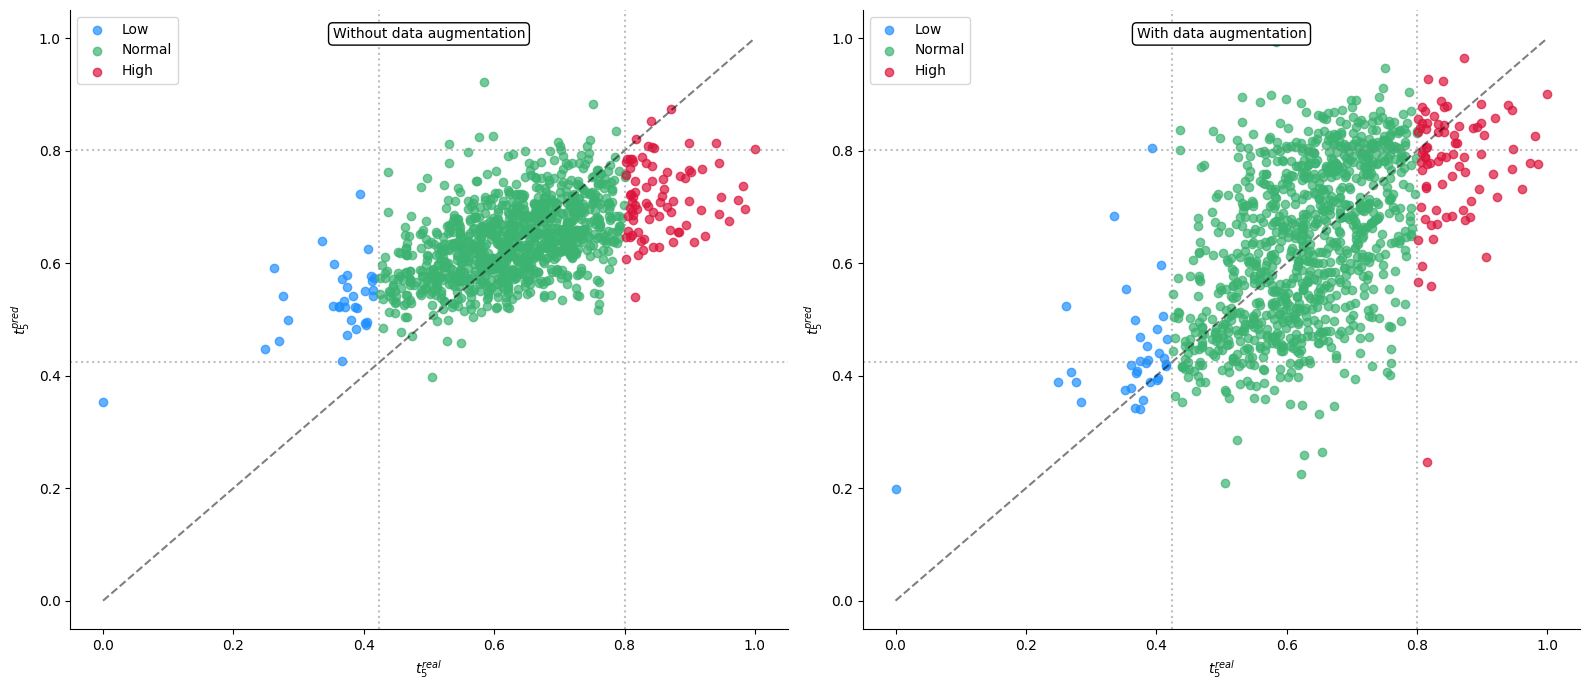

,Scenario,Dataset,Region,DataPoints,MSE,MAE,Accuracy
0,No Augmentation,train,low,223,1.014125,0.938597,2.242152
1,No Augmentation,train,normal,4435,0.188953,0.346996,99.120631
2,No Augmentation,train,high,360,0.704653,0.738482,13.333333
3,No Augmentation,val,low,52,1.546094,1.076819,3.846154
4,No Augmentation,val,normal,945,0.210093,0.358933,98.941799
5,No Augmentation,val,high,78,0.745500,0.769094,10.256410
6,No Augmentation,test,low,34,1.027790,0.939025,2.941176
7,No Augmentation,test,normal,961,0.196604,0.354685,98.751301
8,No Augmentation,test,high,81,0.711397,0.743989,11.111111
9,Augmentation,train,low,4435,0.335638,0.437027,52.717024


In [4]:
import pandas as pd
from google.colab import drive
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Mohammad/CooperStandard')

# Configuration parameters.
file_path = "/content/drive/MyDrive/Mohammad/CooperStandard/DataOn2025Jan08.xlsx"
sheet_names = ["NES170K07Line2", "NES170K07Line1"]
compound_name = "170K"
variables = [
    "batch_number", "MDRTorqueS1", "MDRTorqueS2",
    "mh", "ml", "TimeAtML", "TimeAtML_min", "ml_min",
    "start_time", "end_time", "t5"
]

# Instantiate the experiment runner.
experiment_170K = ExperimentRunner(file_path, sheet_names, compound_name, variables)

# Run experiments for both scenarios.
results_no_aug_170K = experiment_170K.run_experiment(use_augmentation=False)
results_aug_170K = experiment_170K.run_experiment(use_augmentation=True)

# Build a results DataFrame.
rows = []
for scenario, result in [("No Augmentation", results_no_aug_170K), ("Augmentation", results_aug_170K)]:
    for dataset in ["train", "val", "test"]:
        dp_counts = result["datapoints"][dataset]
        perf = result["performance"][dataset]
        for region in ["low", "normal", "high"]:
            row = {
                "Scenario": scenario,
                "Dataset": dataset,
                "Region": region,
                "DataPoints": dp_counts.get(region, 0),
                "MSE": perf.get(region, {}).get("mse", None),
                "MAE": perf.get(region, {}).get("mae", None),
                "Accuracy": perf.get(region, {}).get("accuracy", None)
            }
            rows.append(row)

create_combined_plot(results_no_aug_170K, results_aug_170K, experiment_170K, compound_name)
results_df_170K = pd.DataFrame(rows)
results_df_170K

# **2060C05**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using original training data without augmentation.
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Augmenting training data for balancing...
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


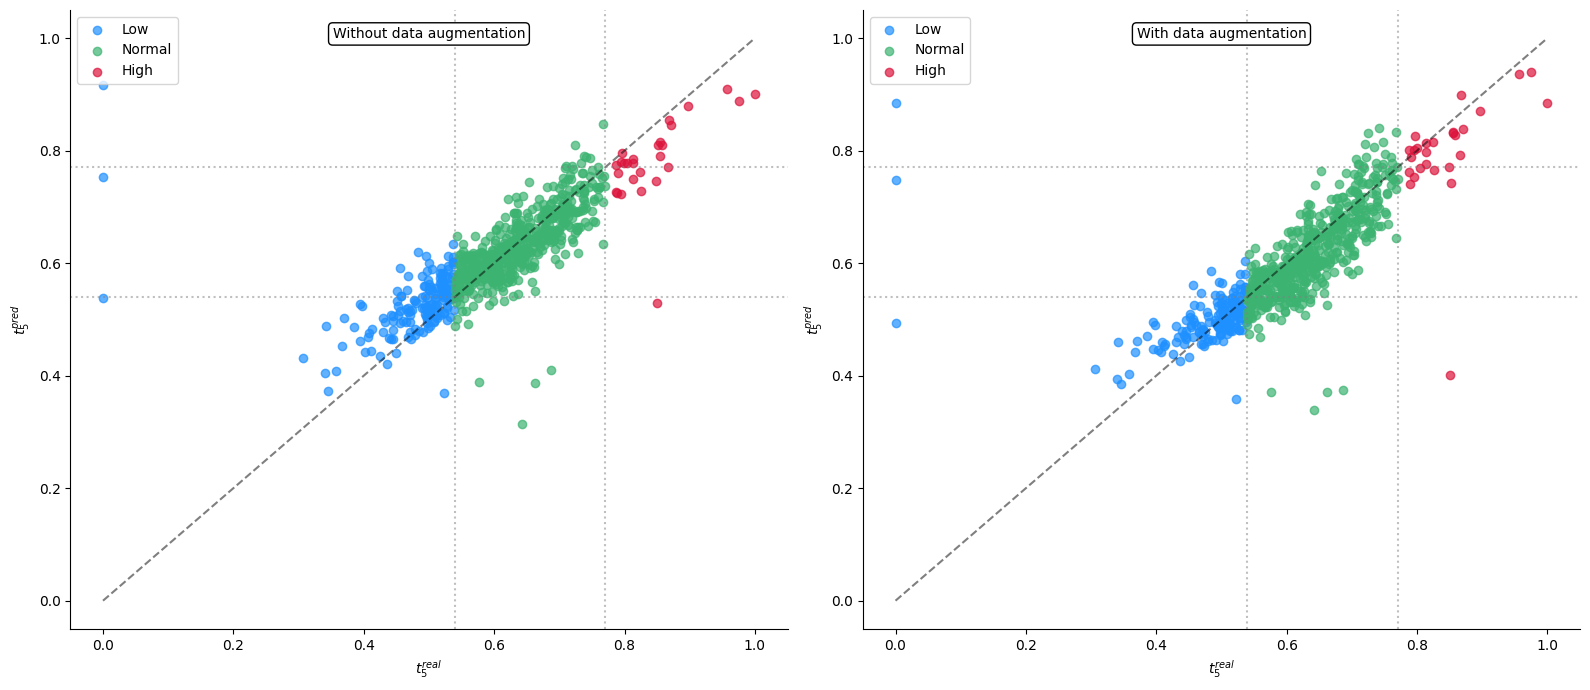

,Scenario,Dataset,Region,DataPoints,MSE,MAE,Accuracy
0,No Augmentation,train,low,802,0.350751,0.351284,61.827284
1,No Augmentation,train,normal,2280,0.083327,0.212159,95.000000
2,No Augmentation,train,high,160,0.189167,0.348831,62.500000
3,No Augmentation,val,low,162,0.231925,0.336672,56.172840
4,No Augmentation,val,normal,493,0.080969,0.204891,94.726166
5,No Augmentation,val,high,40,0.219676,0.379833,47.500000
6,No Augmentation,test,low,162,0.570762,0.372121,60.493827
7,No Augmentation,test,normal,506,0.082078,0.202939,94.861660
8,No Augmentation,test,high,27,0.294561,0.384256,62.962963
9,Augmentation,train,low,2280,0.225972,0.221123,87.307861


In [5]:
import pandas as pd
from google.colab import drive
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Mohammad/CooperStandard')

# Configuration parameters.
file_path = "/content/drive/MyDrive/Mohammad/CooperStandard/DataOn2025Jan08.xlsx"
sheet_names = ["NES2060C05Line2", "NES2060C06Line2"]
compound_name = "2060C05"
variables = [
    "batch_number", "MDRTorqueS1", "MDRTorqueS2",
    "mh", "ml", "TimeAtML", "TimeAtML_min", "ml_min",
    "start_time", "end_time", "t5"
]

# Instantiate the experiment runner.
experiment_2060C05 = ExperimentRunner(file_path, sheet_names, compound_name, variables)

# Run experiments for both scenarios.
results_no_aug_2060C05 = experiment_2060C05.run_experiment(use_augmentation=False)
results_aug_2060C05 = experiment_2060C05.run_experiment(use_augmentation=True)

# Build a results DataFrame.
rows = []
for scenario, result in [("No Augmentation", results_no_aug_2060C05), ("Augmentation", results_aug_2060C05)]:
    for dataset in ["train", "val", "test"]:
        dp_counts = result["datapoints"][dataset]
        perf = result["performance"][dataset]
        for region in ["low", "normal", "high"]:
            row = {
                "Scenario": scenario,
                "Dataset": dataset,
                "Region": region,
                "DataPoints": dp_counts.get(region, 0),
                "MSE": perf.get(region, {}).get("mse", None),
                "MAE": perf.get(region, {}).get("mae", None),
                "Accuracy": perf.get(region, {}).get("accuracy", None)
            }
            rows.append(row)

create_combined_plot(results_no_aug_2060C05, results_aug_2060C05, experiment_2060C05, compound_name)
results_df_2060C05 = pd.DataFrame(rows)
results_df_2060C05